In [2]:
!pip install imgaug
!pip install Cython
!pip install pycocotools
!pip install kaggle

In [0]:
# !git clone https://github.com/priya-dwivedi/Deep-Learning

In [0]:
# import os 
# os.chdir('Deep-Learning/mask_rcnn_damage_detection/')

In [0]:
# !python3 custom.py train --dataset=/content/Deep-Learning/mask_rcnn_damage_detection/customImages --weights=coco

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
pwd

'/content'

In [0]:
import os 
os.chdir('/content/gdrive/My Drive/Deep-Learning-master/mask_rcnn_damage_detection')

In [0]:
# ls

In [0]:
# !python3 custom.py train --dataset=/content/gdrive/My\ Drive/Deep-Learning-master/mask_rcnn_damage_detection/customImages --weights=coco

In [5]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import glob

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import custom 

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

custom_WEIGHTS_PATH = "/content/gdrive/My Drive/logs/damage20190621T1102/mask_rcnn_damage_0010.h5"  # TODO: update this path

Using TensorFlow backend.


In [0]:
ROOT_DIR = os.getcwd()

In [8]:
ROOT_DIR

'/content/gdrive/My Drive/Deep-Learning-master/mask_rcnn_damage_detection'

In [0]:
config = custom.CustomConfig()
custom_DIR = os.path.join(ROOT_DIR, "customImages")

In [11]:

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [14]:
# Load validation dataset
dataset = custom.CustomDataset()
dataset.load_custom(custom_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 94
Classes: ['BG', 'damage']


In [15]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

W0624 05:54:32.097213 140123511281536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 05:54:32.108445 140123511281536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 05:54:32.113960 140123511281536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 05:54:32.147649 140123511281536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0624 05:54:32.151134 140123511

In [16]:
# load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

Loading weights  /content/gdrive/My Drive/logs/damage20190621T1102/mask_rcnn_damage_0010.h5
Re-starting from epoch 10


In [17]:
from importlib import reload # was constantly changin the visualization, so I decided to reload it instead of notebook
reload(visualize)

<module 'mrcnn.visualize' from '/content/gdrive/My Drive/Deep-Learning-master/mask_rcnn_damage_detection/mrcnn/visualize.py'>

In [0]:
# pwd

image ID: damage.13.24848991,77.37333037_5.jpg (33) /content/gdrive/My Drive/Deep-Learning-master/mask_rcnn_damage_detection/customImages/val/13.24848991,77.37333037_5.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  117.00000  max:  684.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


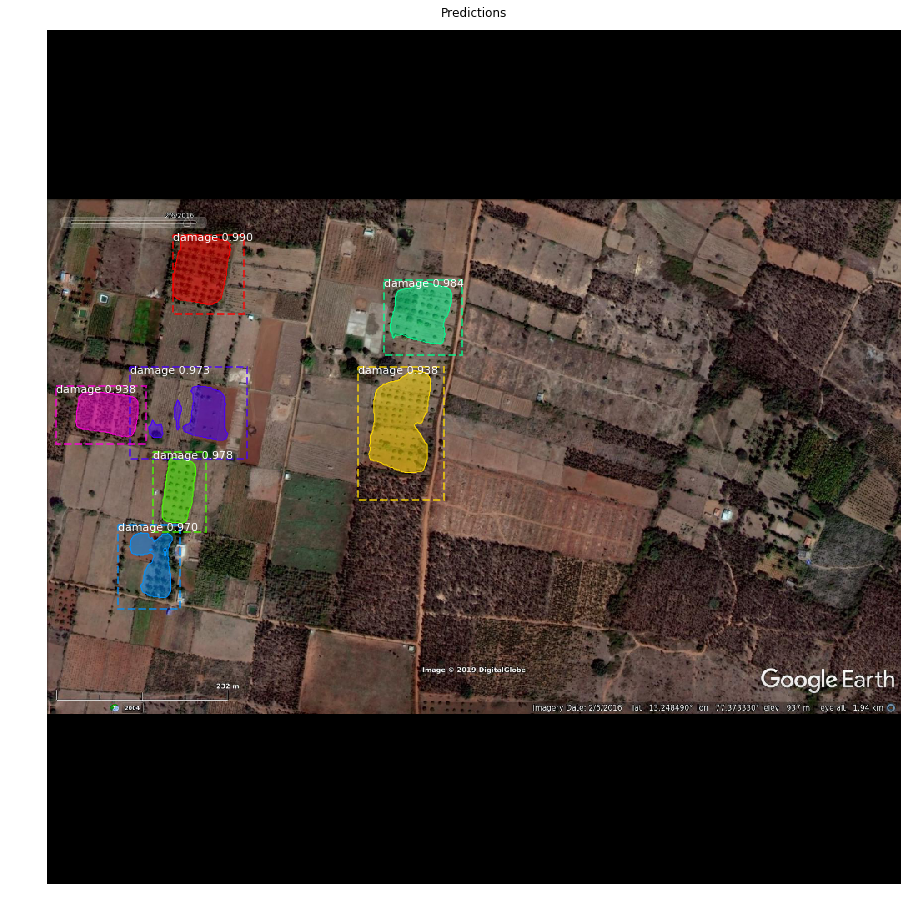

In [0]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [0]:
class_names = ["BG", "damage"]

In [0]:
import glob


image_paths = glob.glob('images/*.jpg')

In [20]:
len(image_paths)

100

In [0]:
# image_paths

In [0]:
def crop(r, i):
  x1 = r['rois'][i][1]
  x2 = r['rois'][i][3]
  y1 = r['rois'][i][0]
  y2 = r['rois'][i][2]
  
  return image[y1:y2, x1:x2, :]


In [0]:
from random import randint

In [0]:

for path in image_paths[90:100]:
  image = skimage.io.imread(path)

  # Run detection
  results = model.detect([image], verbose=0)

  # Visualize results
  r = results[0]
#   masked_imge = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                               class_names, r['scores'])
#   temp_image = masked_imge.astype(np.int32)
#   cv2.imwrite('/content/gdrive/My Drive/Deep-Learning-master/mask_rcnn_damage_detection/result_images/image_{}.jpg'.format(str(randint(1, 10000))), temp_image)
  
  for instance in range(r['rois'].shape[0]):
    result_image = crop(r, instance)
    cv2.imwrite('/content/gdrive/My Drive/Deep-Learning-master/mask_rcnn_damage_detection/cropped_images/image_{}.jpg'.format(str(randint(1, 10000))), result_image)

In [0]:
for instance in range(r['rois'].shape[0]):
  result_image = crop(r, instance)
  cv2.imwrite('/content/gdrive/My Drive/Deep-Learning-master/mask_rcnn_damage_detection/cropped_images/image_{}.jpg'.format(str(randint(1, 10000))), result_image)

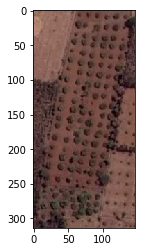

In [107]:
plt.imshow(result_image)

In [0]:
from PIL import Image

from resizeimage import resizeimage


with open('test-image.jpeg', 'r+b') as f:
    with Image.open(f) as image:
        cover = resizeimage.resize_cover(image, [200, 100])
#         cover.save('test-image-cover.jpeg', image.format)

In [110]:
r['rois'].shape[0]

4

In [0]:
# path

In [0]:
# masked_imge

In [0]:

# masked_imge.shape

In [0]:
# # for i in range(len(masked_image)):
# # image = np.empty(masked_imge.shape, dtype = int)
# image = masked_imge.astype(np.int32)
# cv2.imwrite('/content/gdrive/My Drive/Deep-Learning-master/mask_rcnn_damage_detection/result_images/image_{}.jpg'.format(randint(str(randint(1, 10000)))), image)
  

In [0]:
# plt.imshow(masked_imge)

In [0]:
# plt.savefig('/content/gdrive/My Drive/Deep-Learning-master/mask_rcnn_damage_detection/result_images/image.jpg')

In [0]:
masked_imge.shape

In [0]:
#  results = model.detect([image], verbose=0)

In [0]:
# r = results[0]

In [0]:
# print(r['masks'].shape)
# print(image.shape)


Mask R-CNN - Inspect Training Data


In [0]:
# import os
# import sys
# import itertools
# import math
# import logging
# import json
# import re
# import random
# from collections import OrderedDict
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import matplotlib.lines as lines
# from matplotlib.patches import Polygon

# # Root directory of the project
# ROOT_DIR = os.path.abspath("../../")

# # Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
# from mrcnn import utils
# from mrcnn import visualize
# from mrcnn.visualize import display_images
# import mrcnn.model as modellib
# from mrcnn.model import log

%matplotlib inline

In [0]:
# ROOT_DIR

In [0]:
# pwd

In [0]:
# # Run one of the code blocks

# # Shapes toy dataset
# # import shapes
# # config = shapes.ShapesConfig()

# import custom
# config = custom.CustomConfig()
# CUSTOM_DIR = os.path.join(ROOT_DIR, "Deep-Learning-master/mask_rcnn_damage_detection/customImages")
# print(CUSTOM_DIR)

In [0]:
# # Load dataset
# # Get the dataset from the releases page
# # https://github.com/matterport/Mask_RCNN/releases
# dataset = custom.CustomDataset()
# dataset.load_custom(CUSTOM_DIR, "train")

# # Must call before using the dataset
# dataset.prepare()

# print("Image Count: {}".format(len(dataset.image_ids)))
# print("Class Count: {}".format(dataset.num_classes))
# for i, info in enumerate(dataset.class_info):
#     print("{:3}. {:50}".format(i, info['name']))

In [0]:
# # Load and display random samples
# image_ids = np.random.choice(dataset.image_ids, 4)
# for image_id in image_ids:
#     image = dataset.load_image(image_id)
#     mask, class_ids = dataset.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [0]:
# # Load random image and mask.
# image_id = random.choice(dataset.image_ids)
# image = dataset.load_image(image_id)
# mask, class_ids = dataset.load_mask(image_id)
# # Compute Bounding box
# bbox = utils.extract_bboxes(mask)

# # Display image and additional stats
# print("image_id ", image_id, dataset.image_reference(image_id))
# log("image", image)
# log("mask", mask)
# log("class_ids", class_ids)
# log("bbox", bbox)
# # Display image and instances
# visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [0]:
# # Load random image and mask.
# image_id = np.random.choice(dataset.image_ids, 1)[0]
# image = dataset.load_image(image_id)
# mask, class_ids = dataset.load_mask(image_id)
# original_shape = image.shape
# # Resize
# image, window, scale, padding, _ = utils.resize_image(
#     image, 
#     min_dim=config.IMAGE_MIN_DIM, 
#     max_dim=config.IMAGE_MAX_DIM,
#     mode=config.IMAGE_RESIZE_MODE)
# mask = utils.resize_mask(mask, scale, padding)
# # Compute Bounding box
# bbox = utils.extract_bboxes(mask)

# # Display image and additional stats
# print("image_id: ", image_id, dataset.image_reference(image_id))
# print("Original shape: ", original_shape)
# log("image", image)
# log("mask", mask)
# log("class_ids", class_ids)
# log("bbox", bbox)
# # Display image and instances
# visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [0]:

# image_id = np.random.choice(dataset.image_ids, 1)[0]
# image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
#     dataset, config, image_id, use_mini_mask=False)

# log("image", image)
# log("image_meta", image_meta)
# log("class_ids", class_ids)
# log("bbox", bbox)
# log("mask", mask)

# display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [0]:

# visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [0]:
#tensorboard,accuracy graph

#images actual ,mask annotations, predictions
#all experiments you have done
#all errors list in image
# other experiments to do 
#change hyper parameter based on research paper
#1500 manually 